# Video face tracking and recognition

The idea of this project is to build a example flow for understanding of real time video.

The process consists of some steps:
Person Detection -> Face detection -> Face recognition -> Face store
  |-> Video Understanding -> 


## Inialize face detection and tracking

In [1]:
from ultralytics import YOLO
print("asdf")
base_model = YOLO("yolov11s-face.pt")
base_model.export(format="engine")
model = YOLO("yolov11s-face.engine")
stream = model.track("../dataset/bar_cam_1.mp4",
                      conf=0.75,
                      stream=True,
                      #verbose=False,
                    )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
asdf
WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.113 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX A4500, 20171MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'yolov11s-face.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 1.8s, saved as 'yolov11s-face.onnx' (36.2 MB)

TensorRT: starting export with TensorRT 10.9.0.34...
[04/22/2025-12:33:01] [TRT] [I] [MemUsageChange] Init CUDA: CPU -2, GPU +0, now: CPU 1019, GPU 4

[04/22/2025-12:34:32] [TRT] [I] Loaded engine size: 46 MiB
[04/22/2025-12:34:32] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +35, now: CPU 0, GPU 76 (MiB)


In [2]:
detections = {}

for frame_i, detection in enumerate(stream):
    boxes = detection.boxes

    for box in boxes:
        detectionid = int(box.id.item()) if hasattr(box, 'id') and box.id is not None else None
        confidence = float(box.conf.item()) if hasattr(box, 'conf') else None

        if detectionid is None:
            continue
        
        if detectionid not in detections:
            detections[detectionid] = {}

        x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy()[0])
        face = detection.orig_img[y1:y2, x1:x2]

        detections[detectionid][frame_i] = {
            'face': face,
            'confidence': confidence
        }



video 1/1 (frame 1/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 2 faces, 3.0ms
video 1/1 (frame 2/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 2 faces, 3.0ms
video 1/1 (frame 3/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 4/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 5/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 6/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 7/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 8/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 9/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0ms
video 1/1 (frame 10/7949) /workdir/face_recognition/../dataset/bar_cam_1.mp4: 640x640 3 faces, 3.0m

## Display faces
Display the detected face tracking groups

Detection: 1


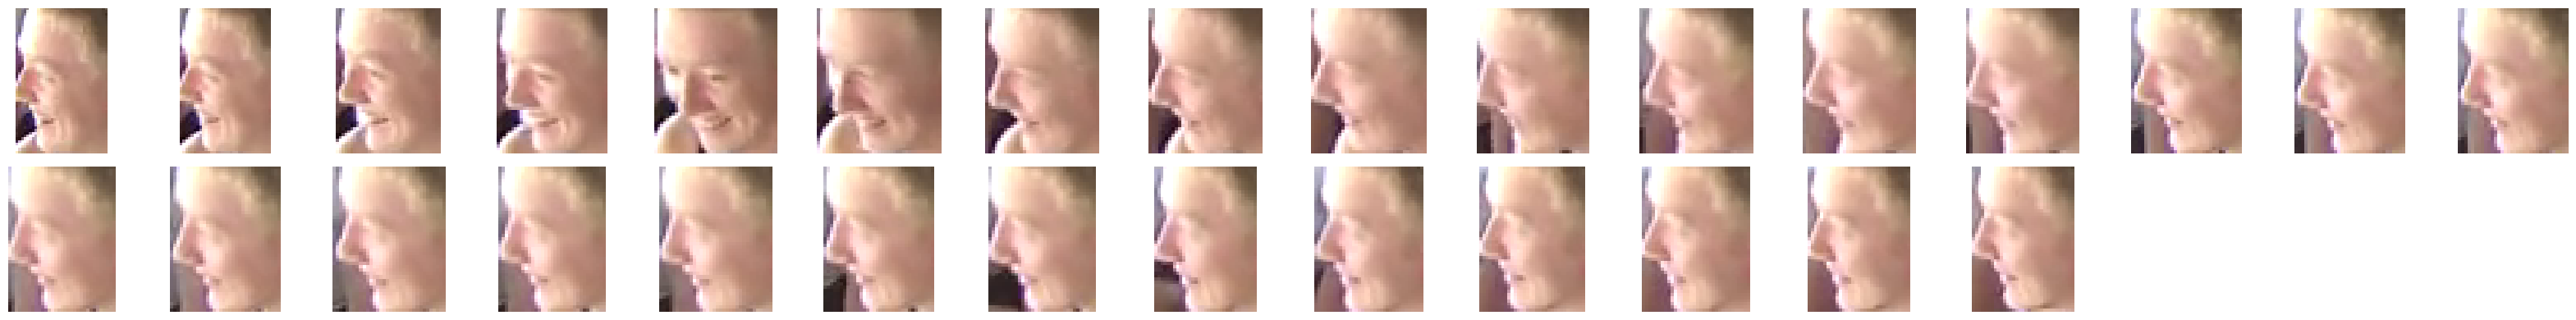

Detection: 2


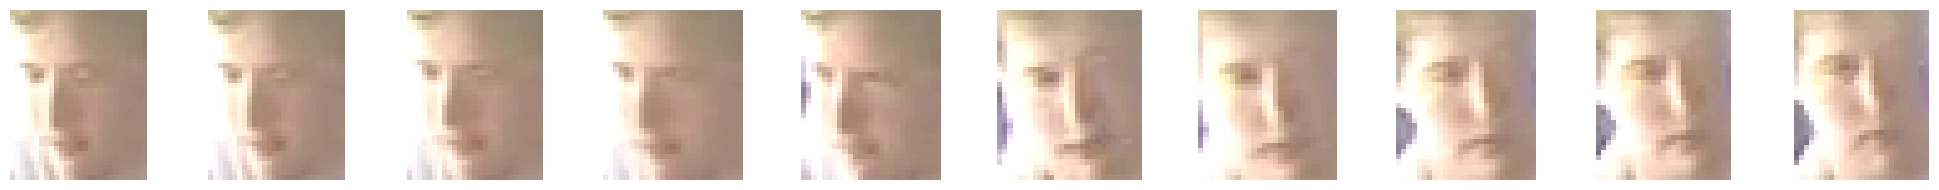

Detection: 6


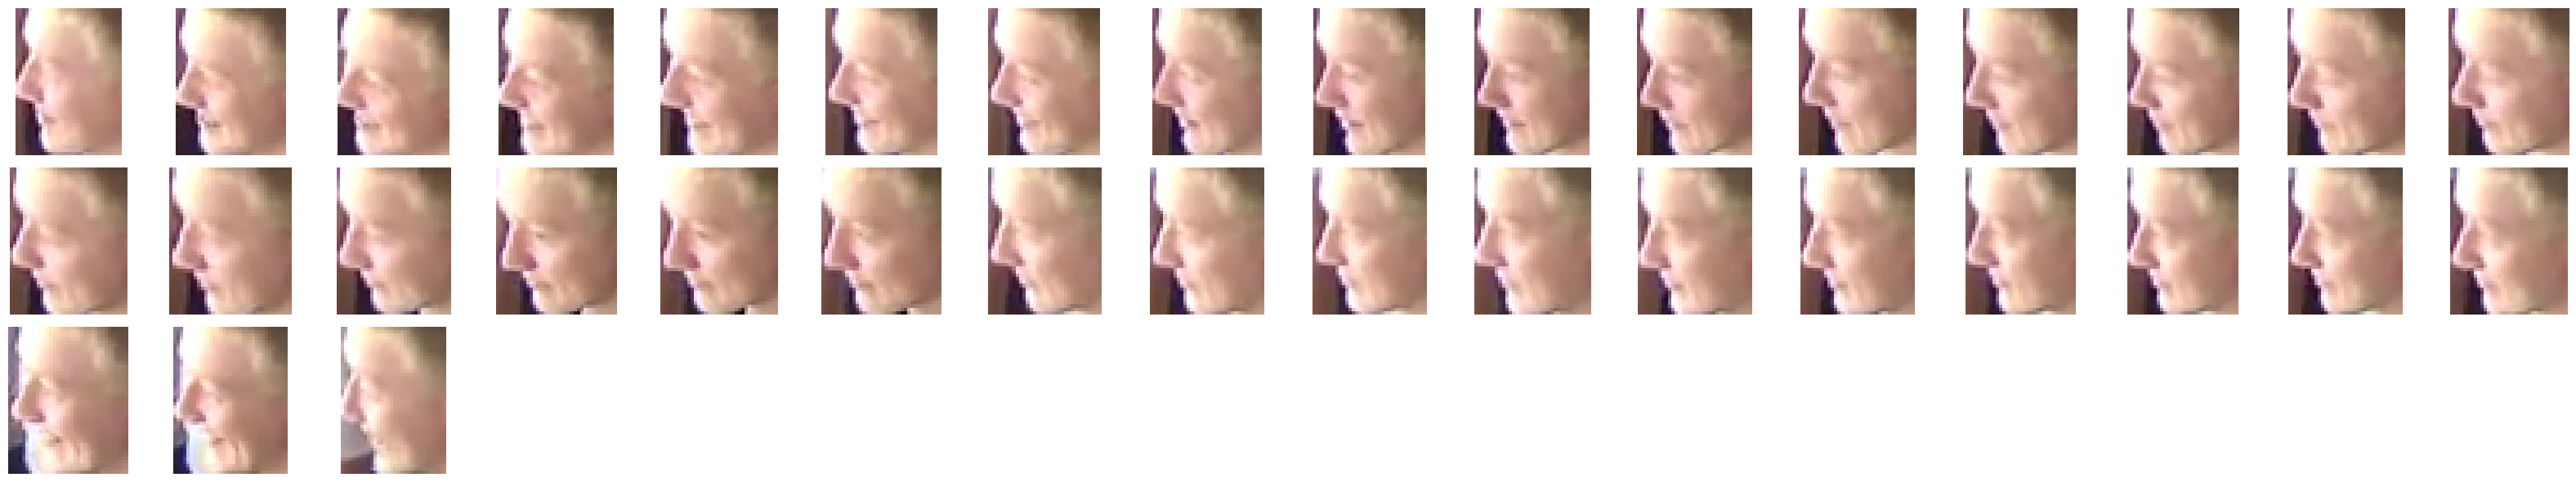

Detection: 8


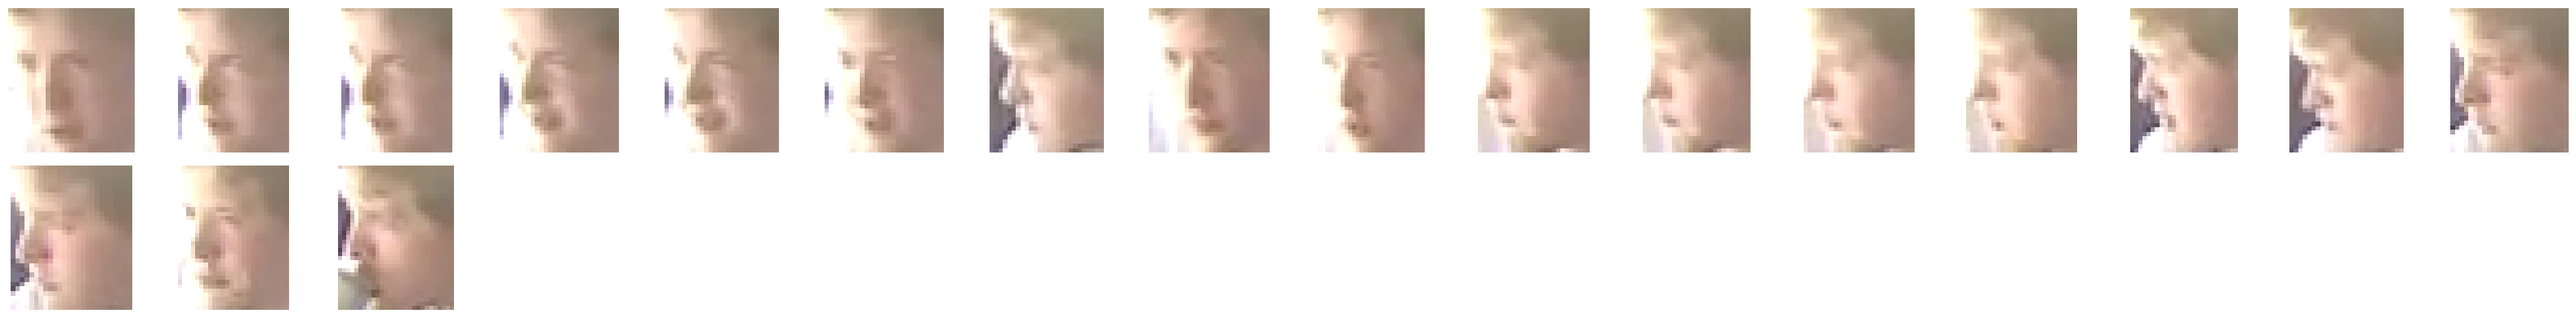

Detection: 18


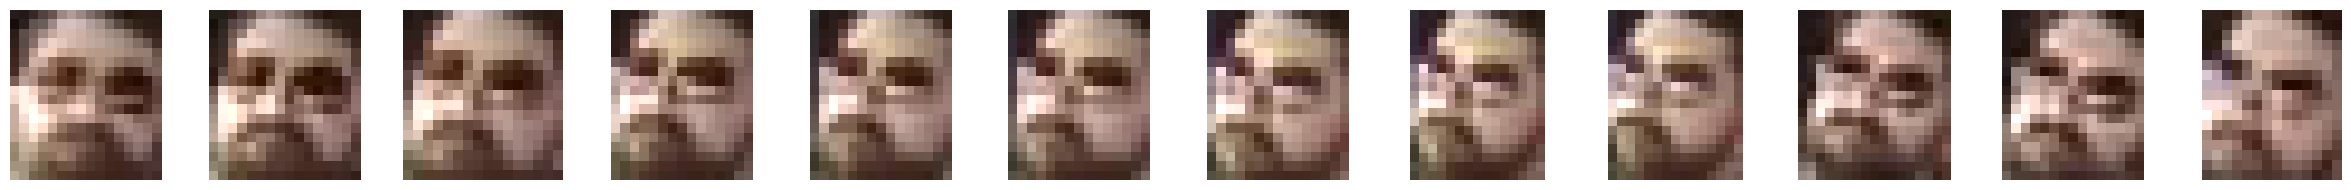

Detection: 20


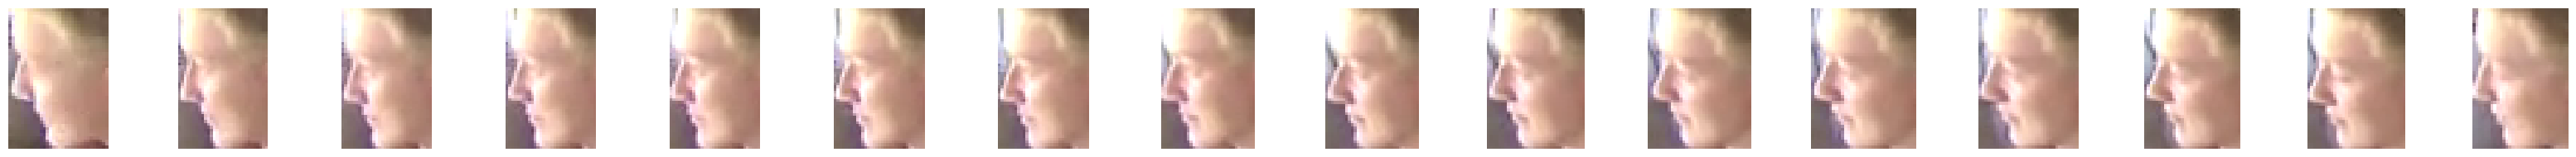

Detection: 26


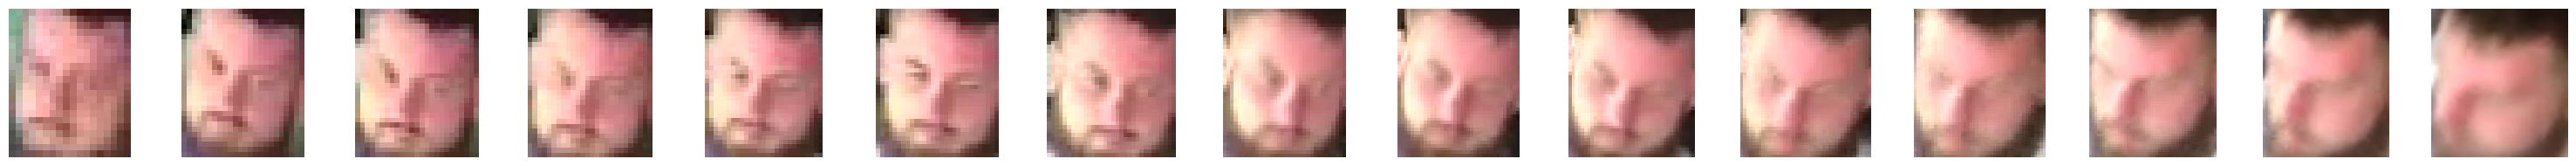

Detection: 29


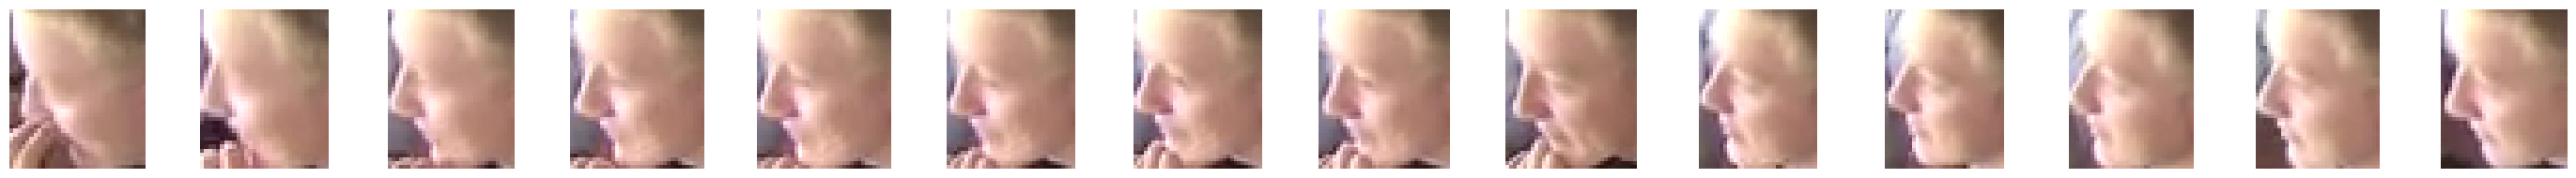

Detection: 34


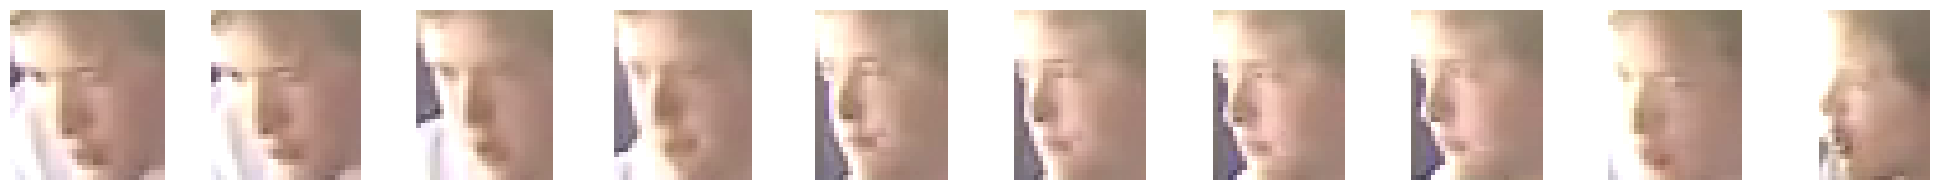

Detection: 35


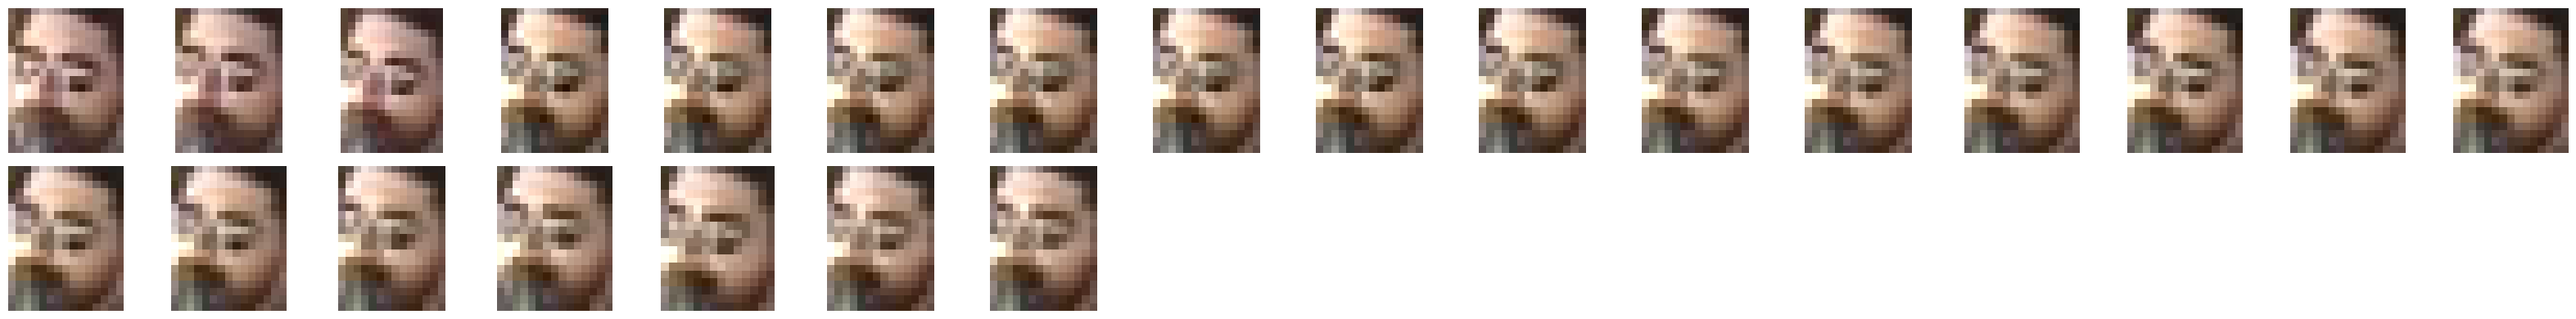

Detection: 37


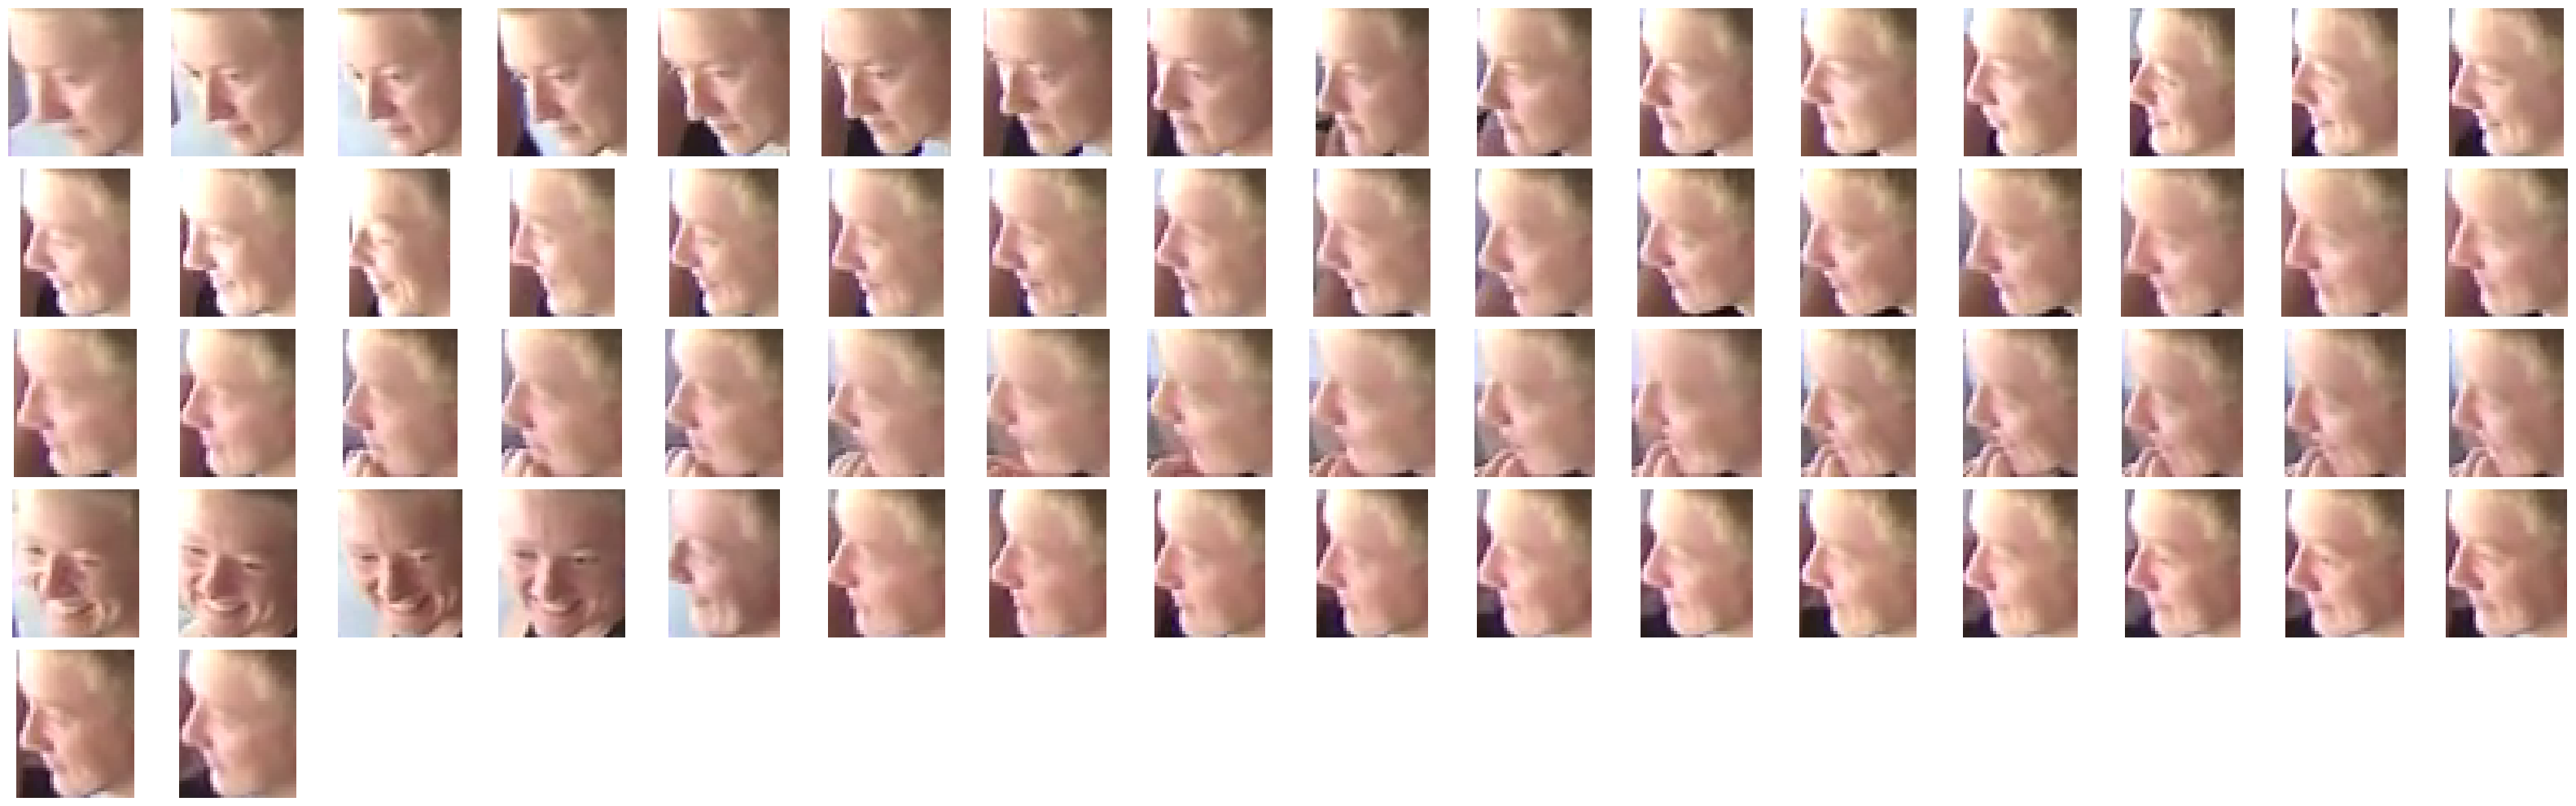

Detection: 39


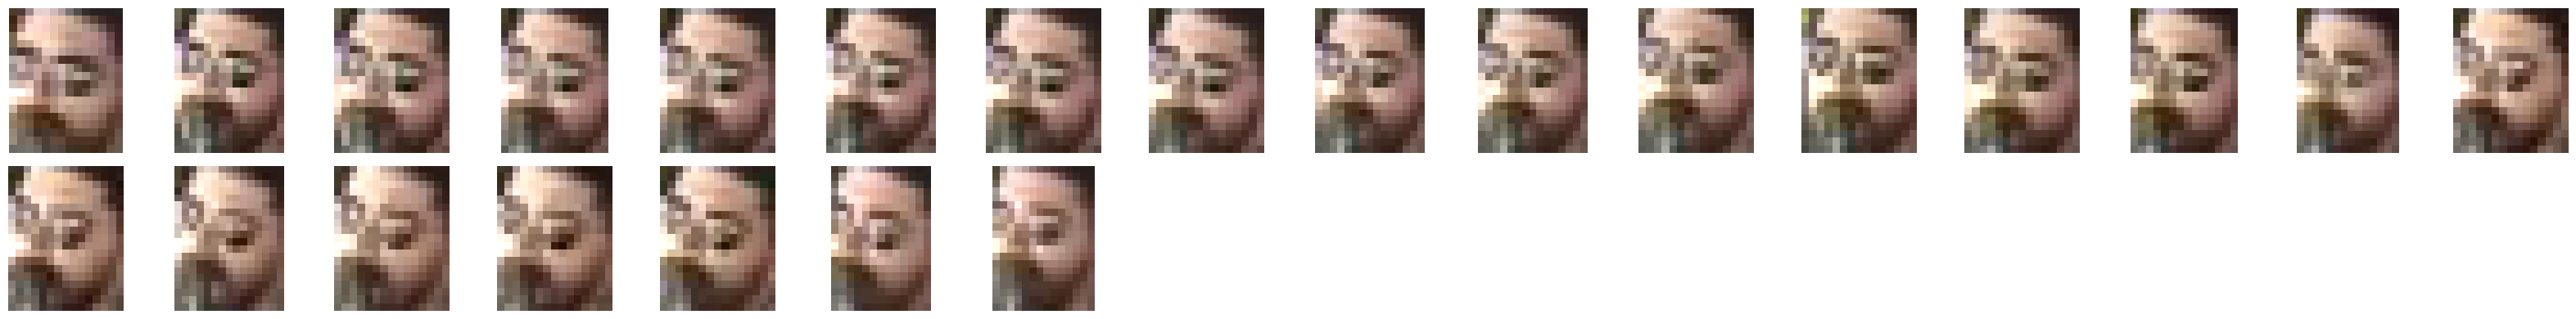

Detection: 68


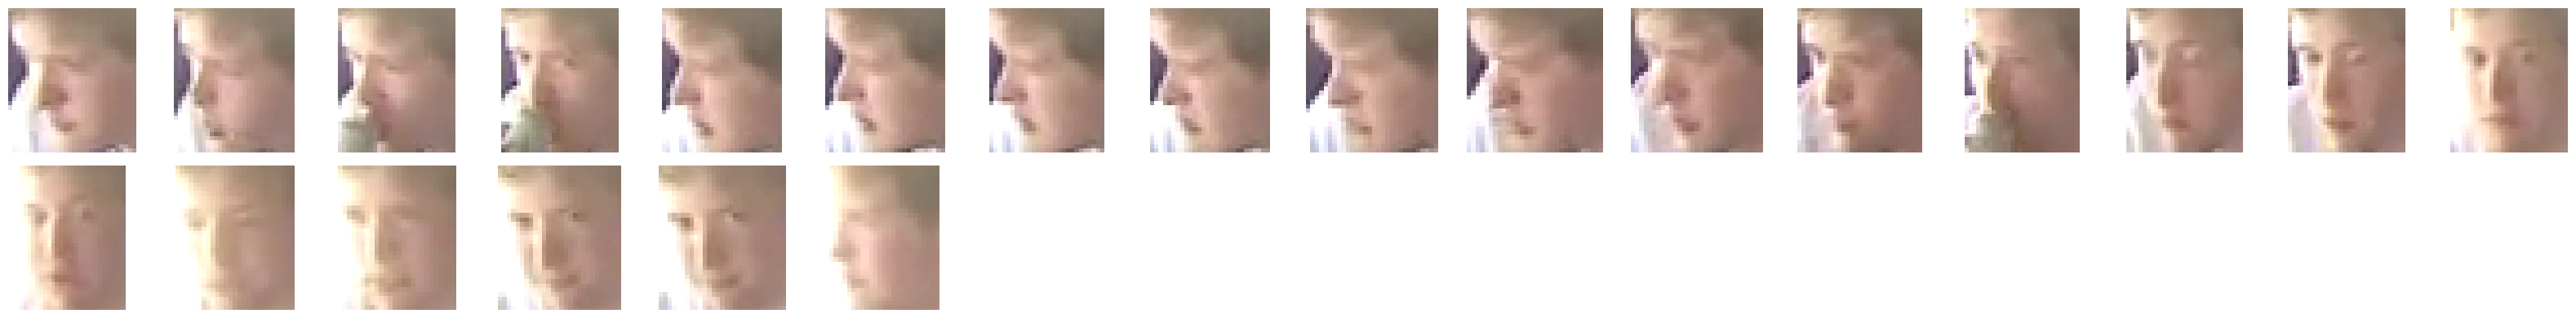

Detection: 75


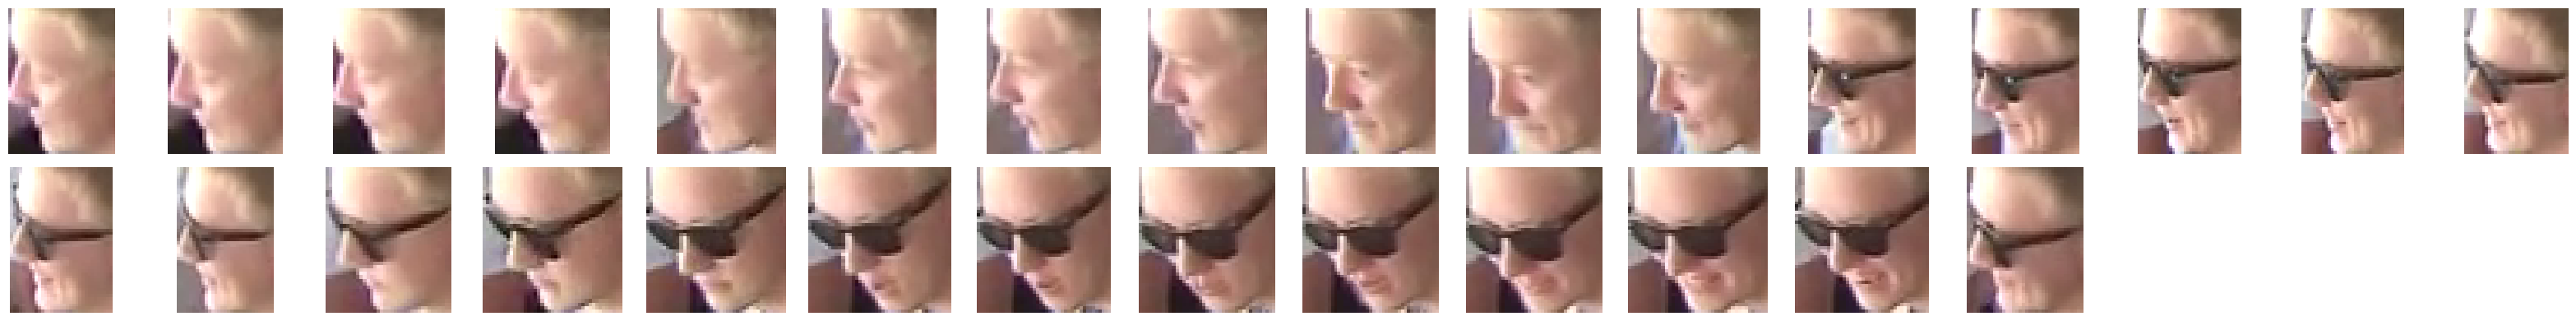

Detection: 77


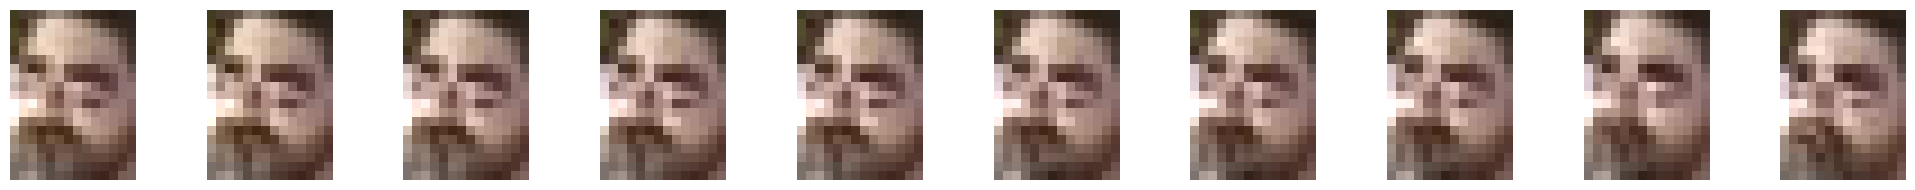

Detection: 81


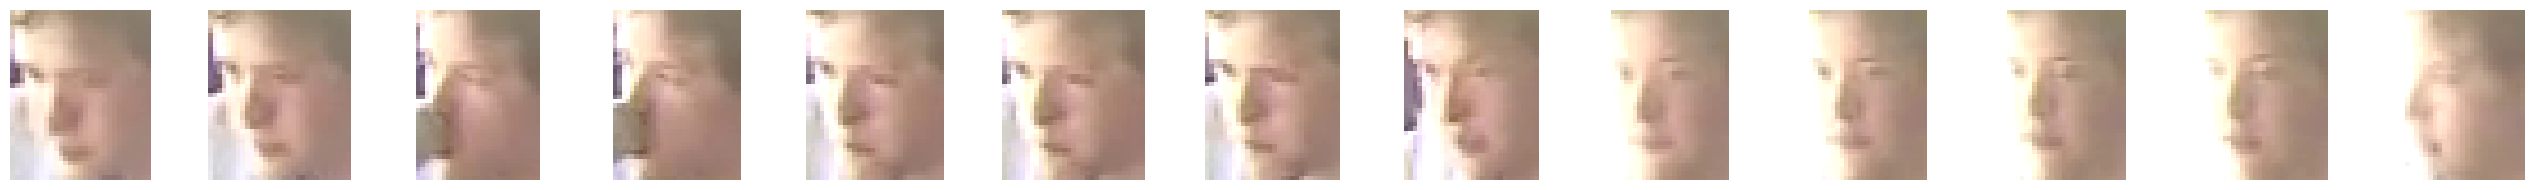

Detection: 83


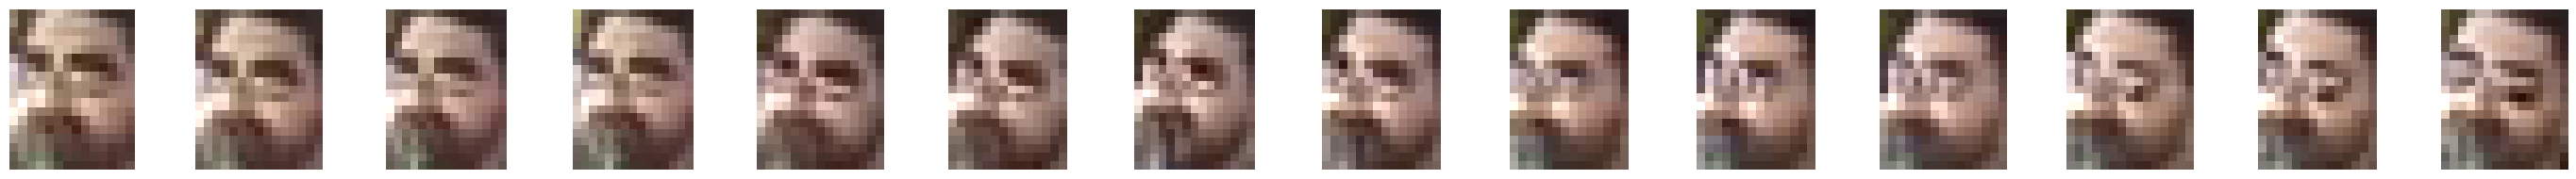

Detection: 84


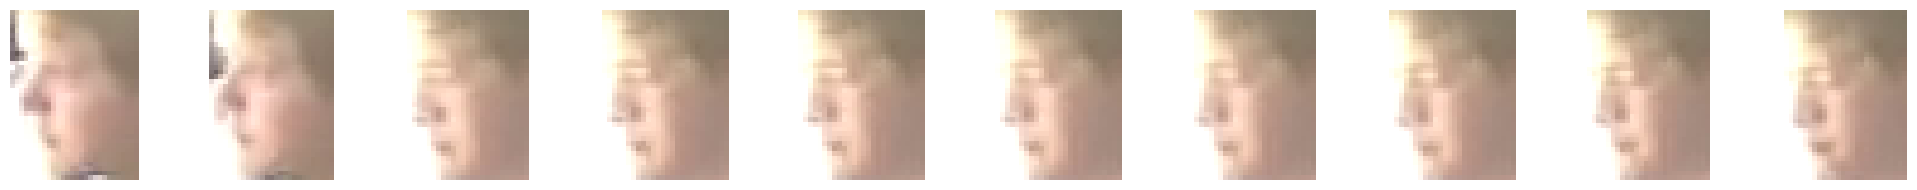

Detection: 85


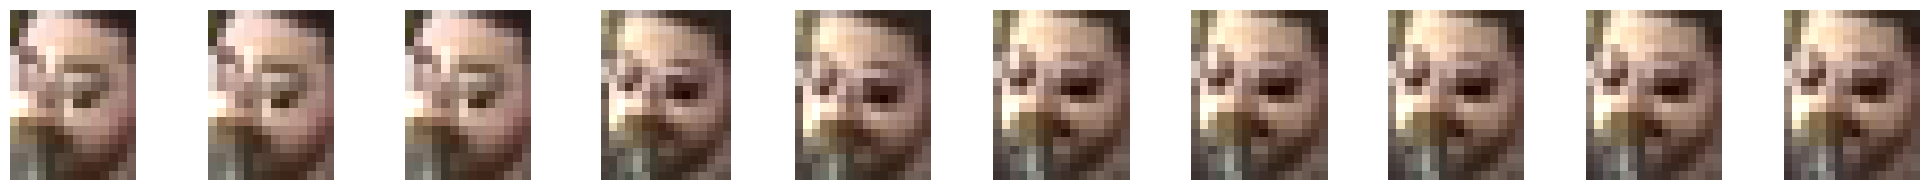

Detection: 89


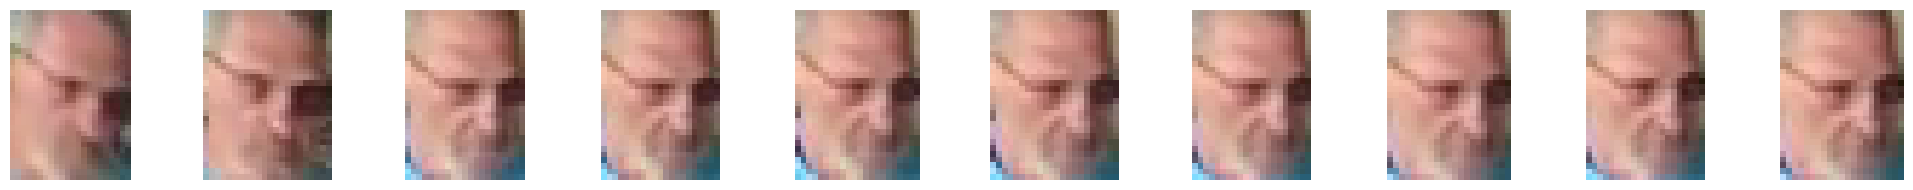

Detection: 96


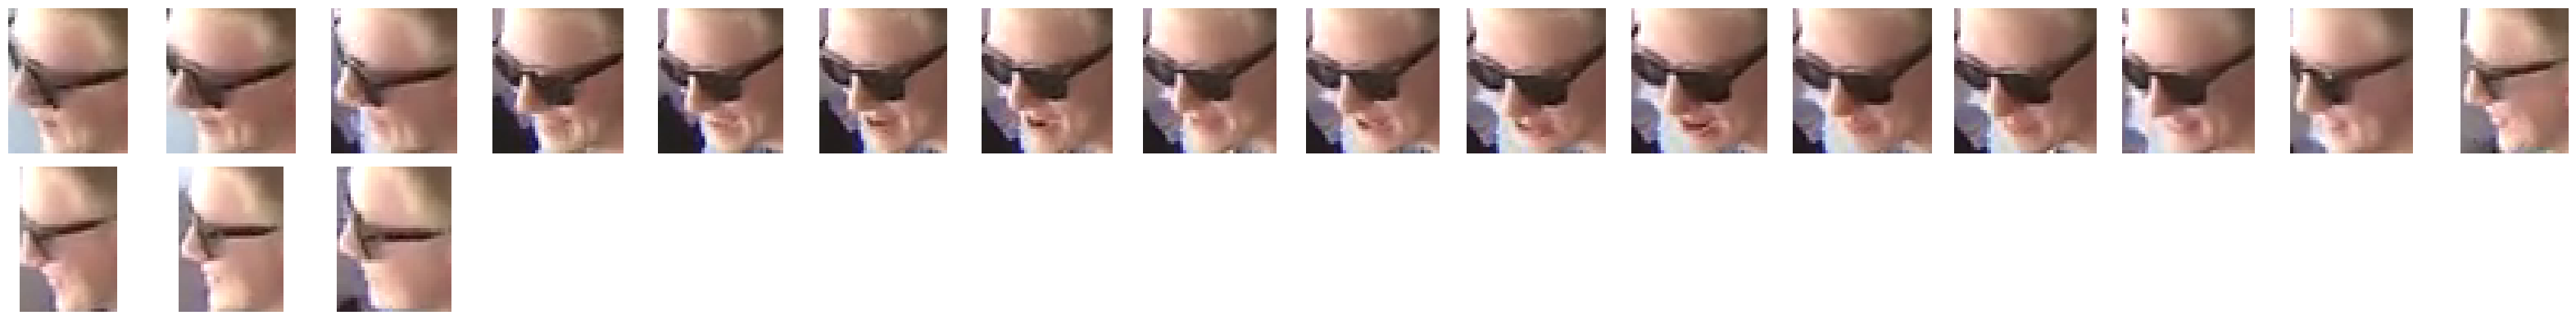

Detection: 100


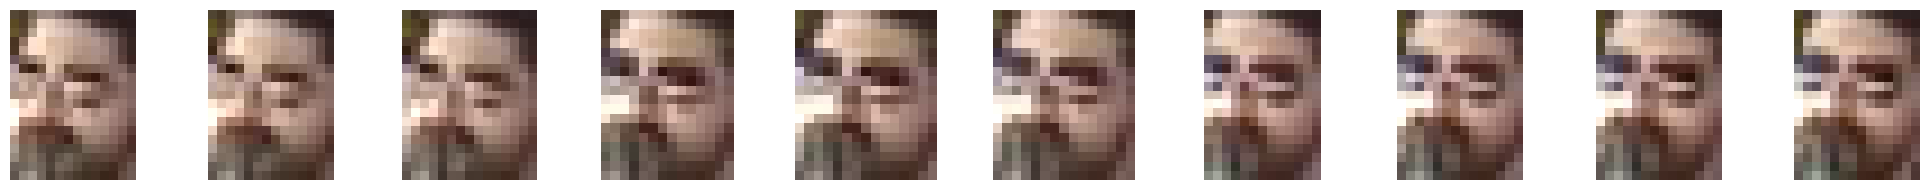

Detection: 106


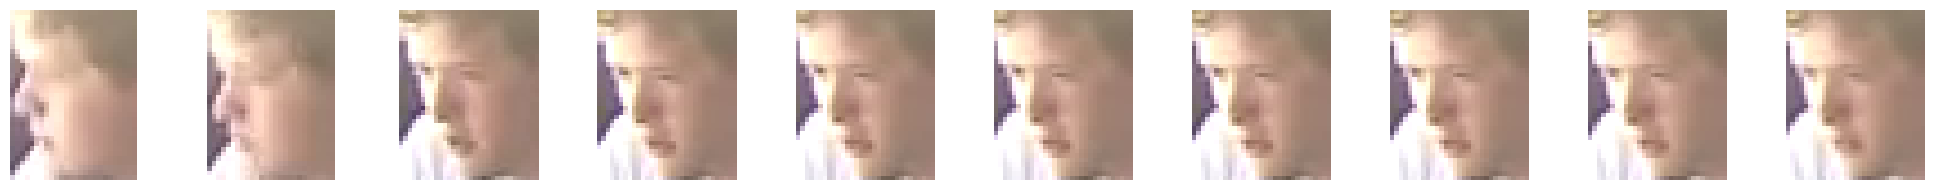

Detection: 109


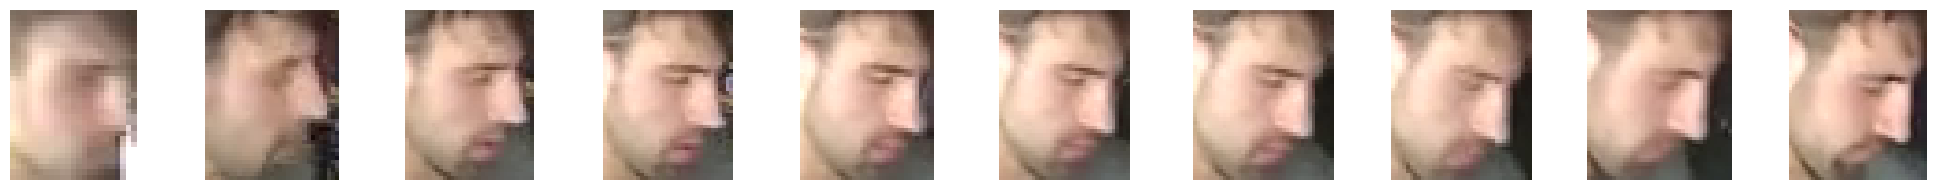

Detection: 111


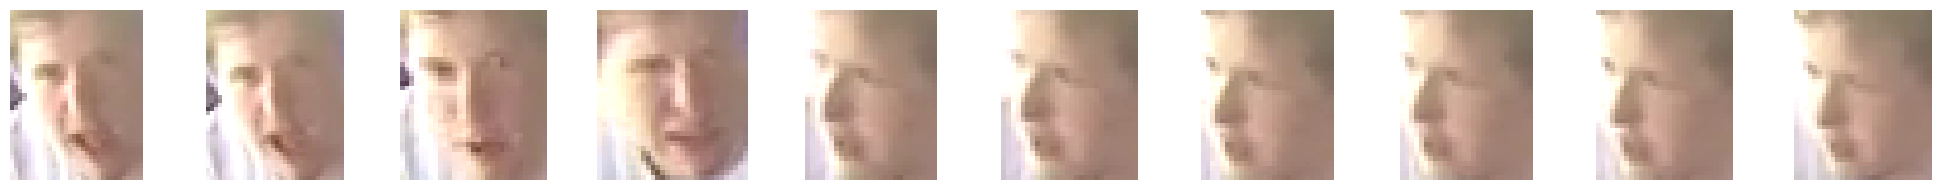

Detection: 113


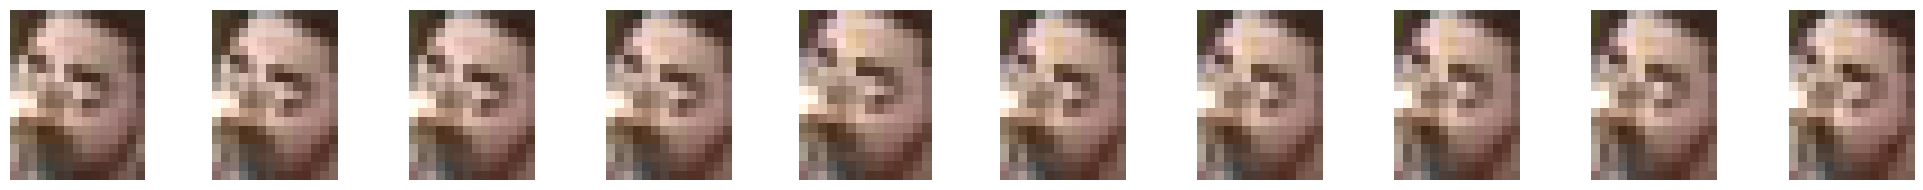

Detection: 114


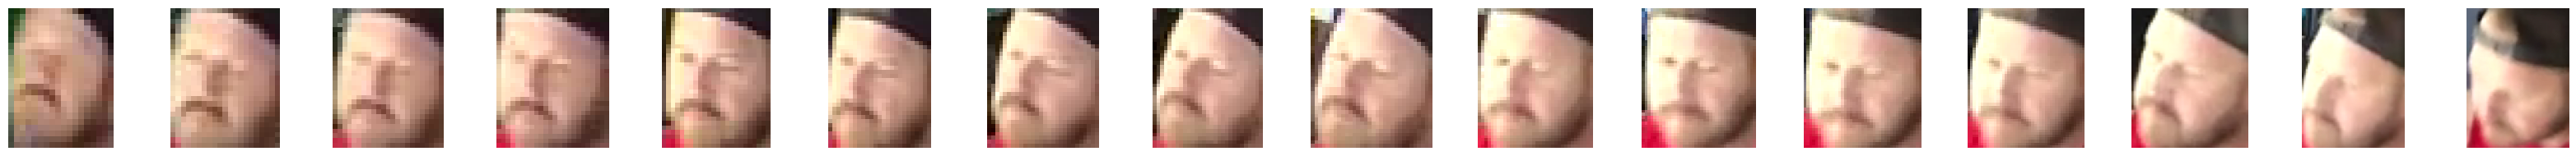

Detection: 119


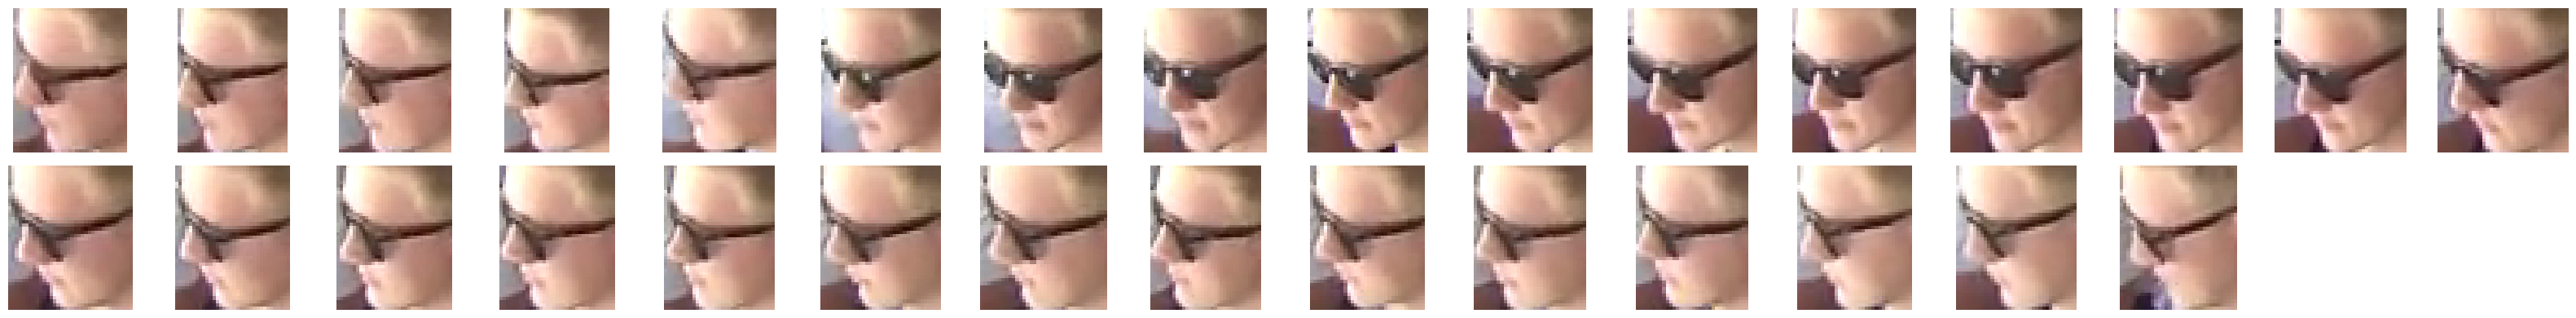

Detection: 120


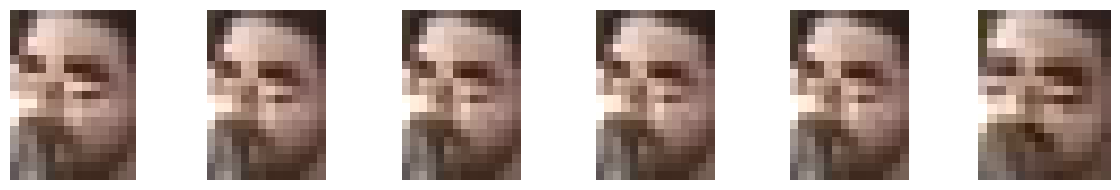

Detection: 132


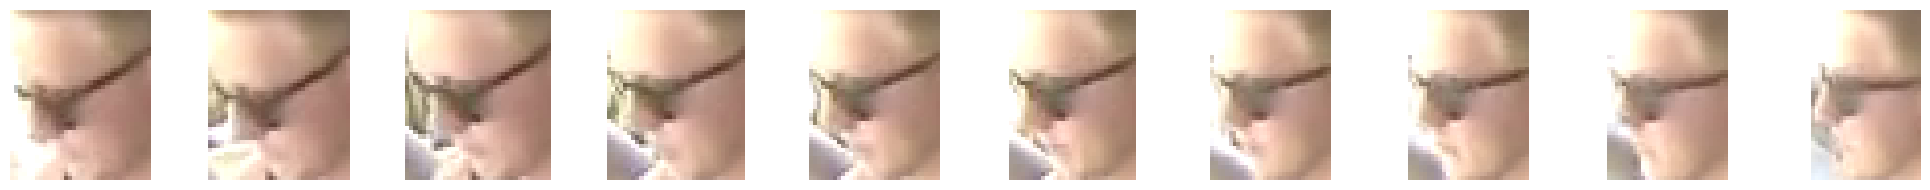

Detection: 137


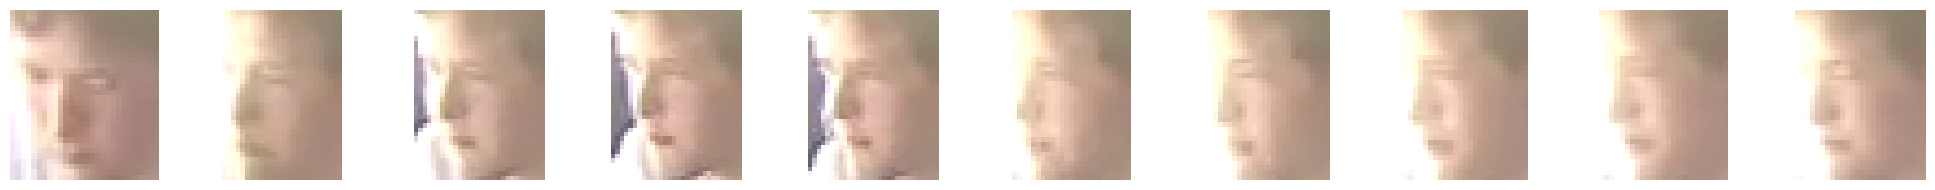

Detection: 139


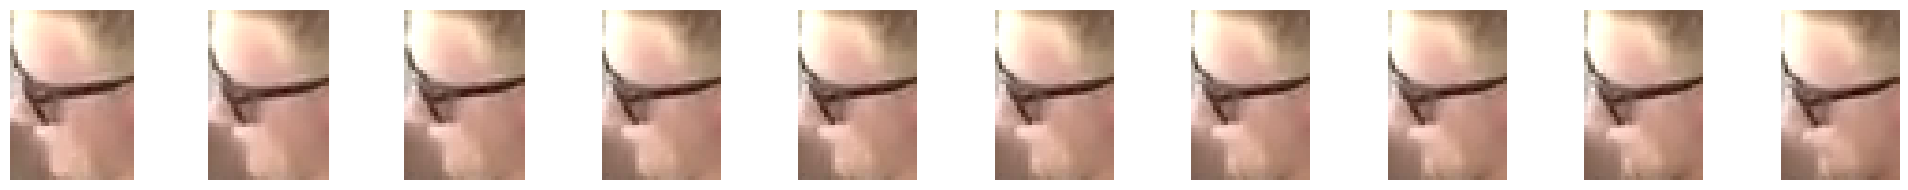

Detection: 141


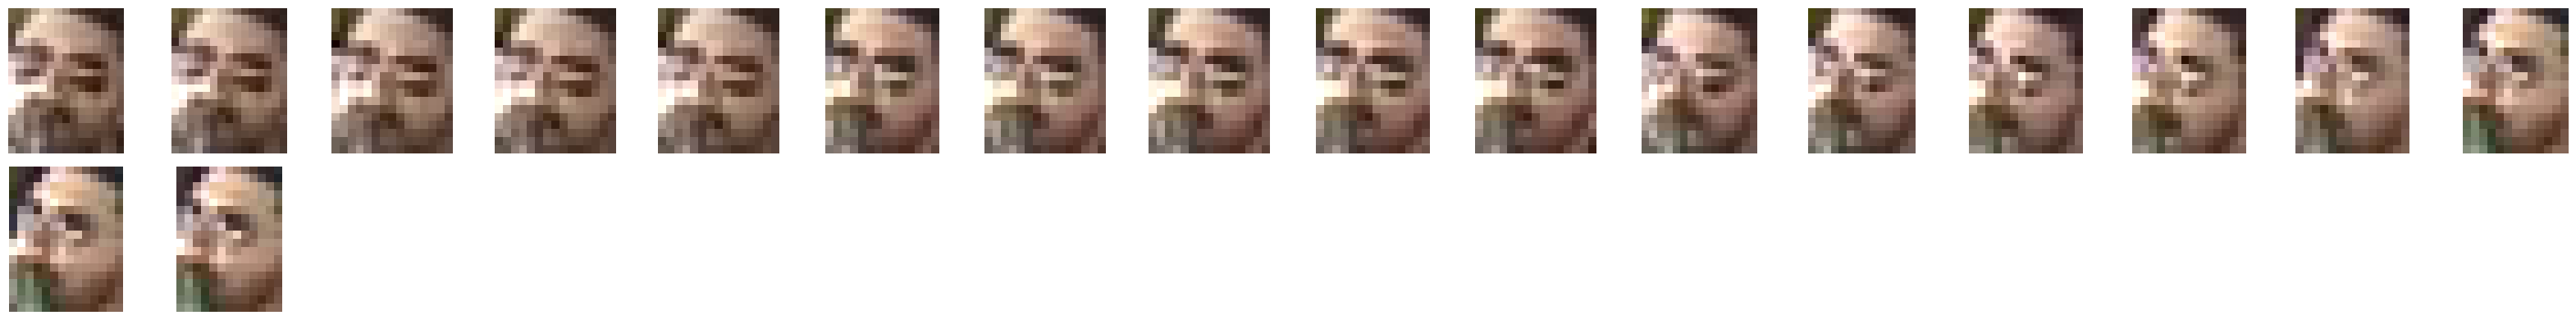

Detection: 143


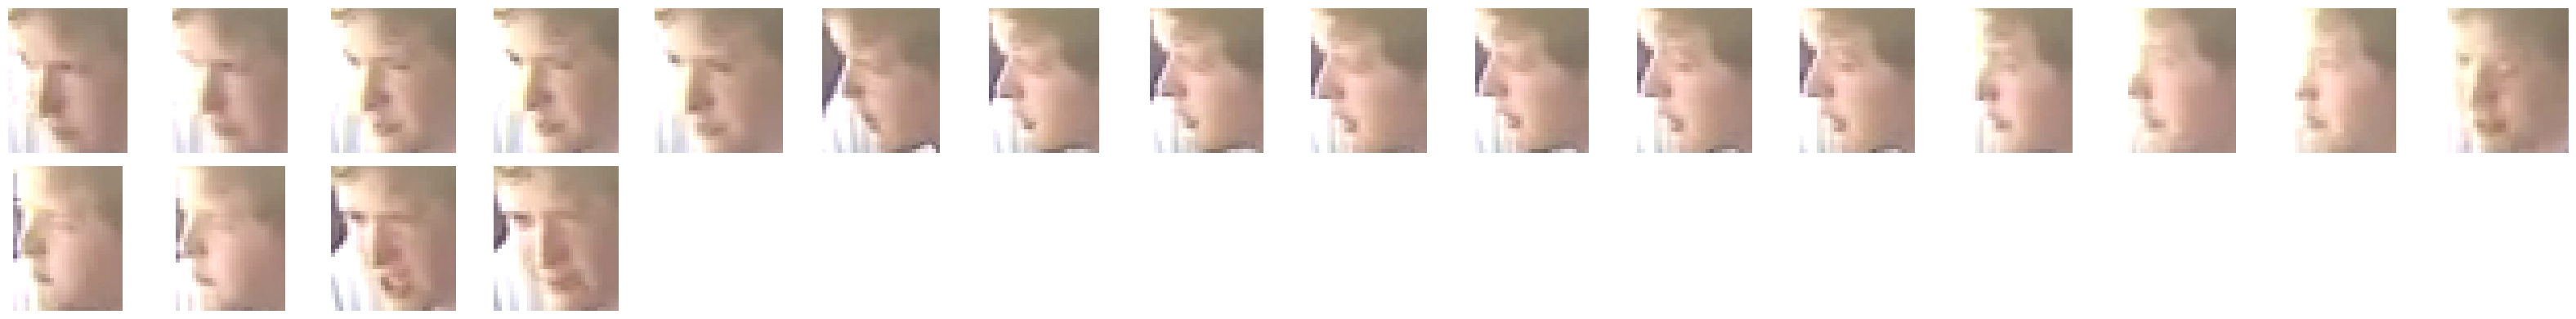

Detection: 147


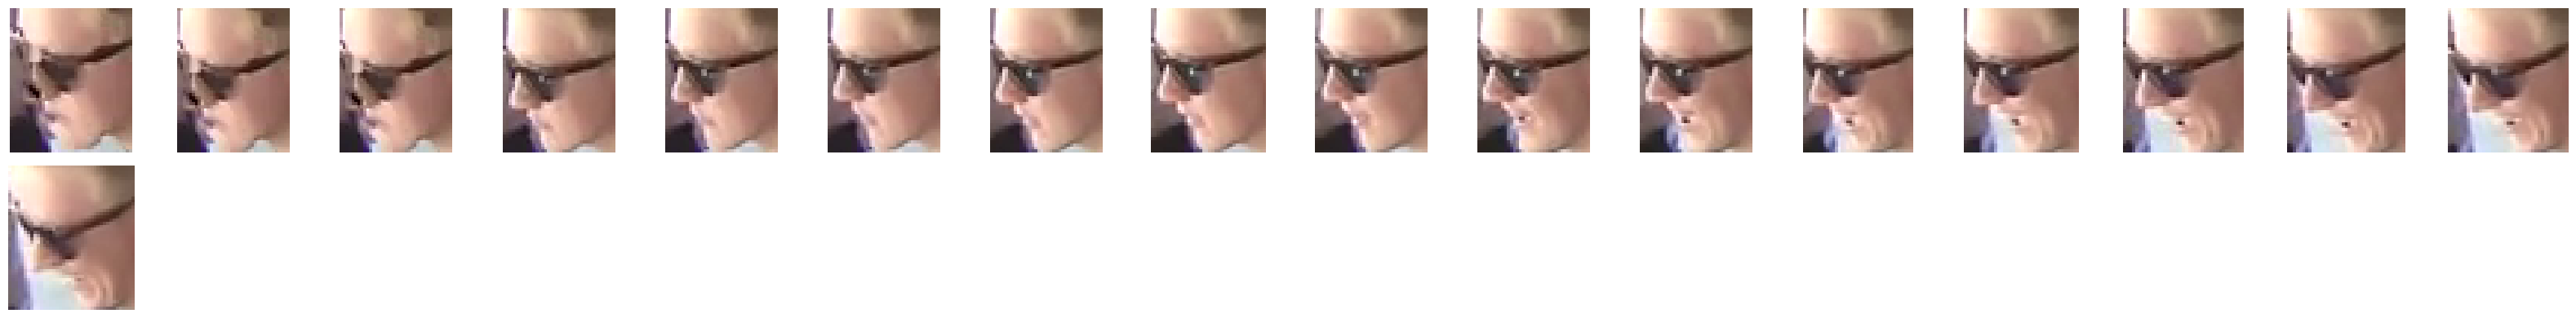

Detection: 149


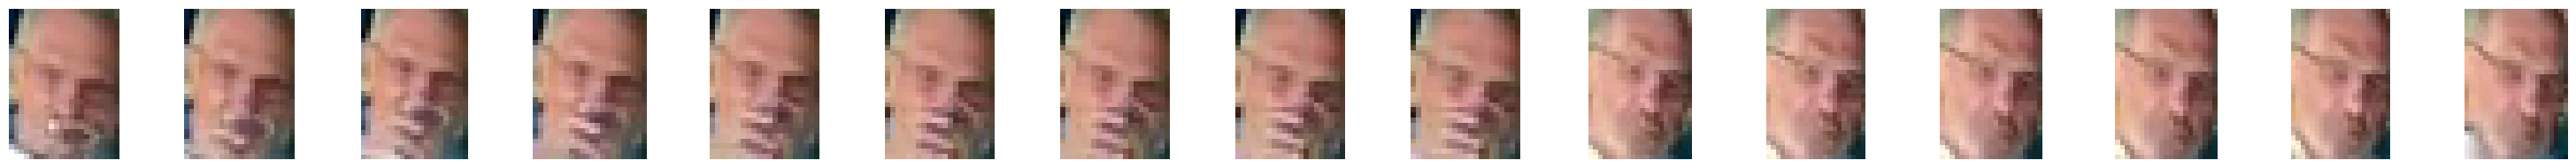

Detection: 156


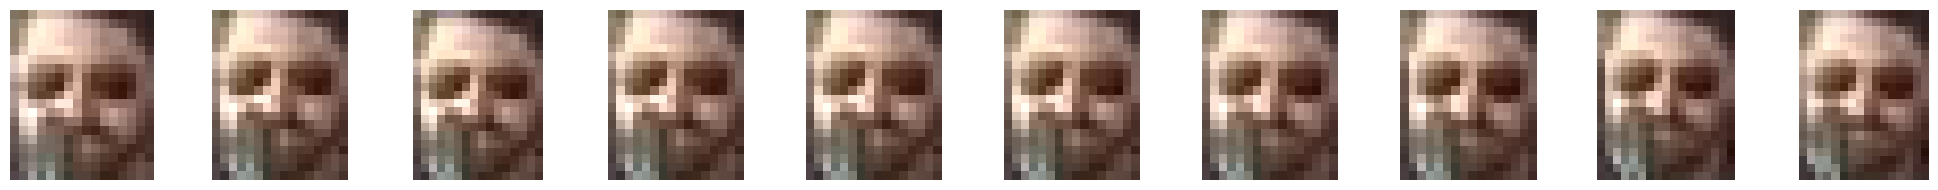

Detection: 157


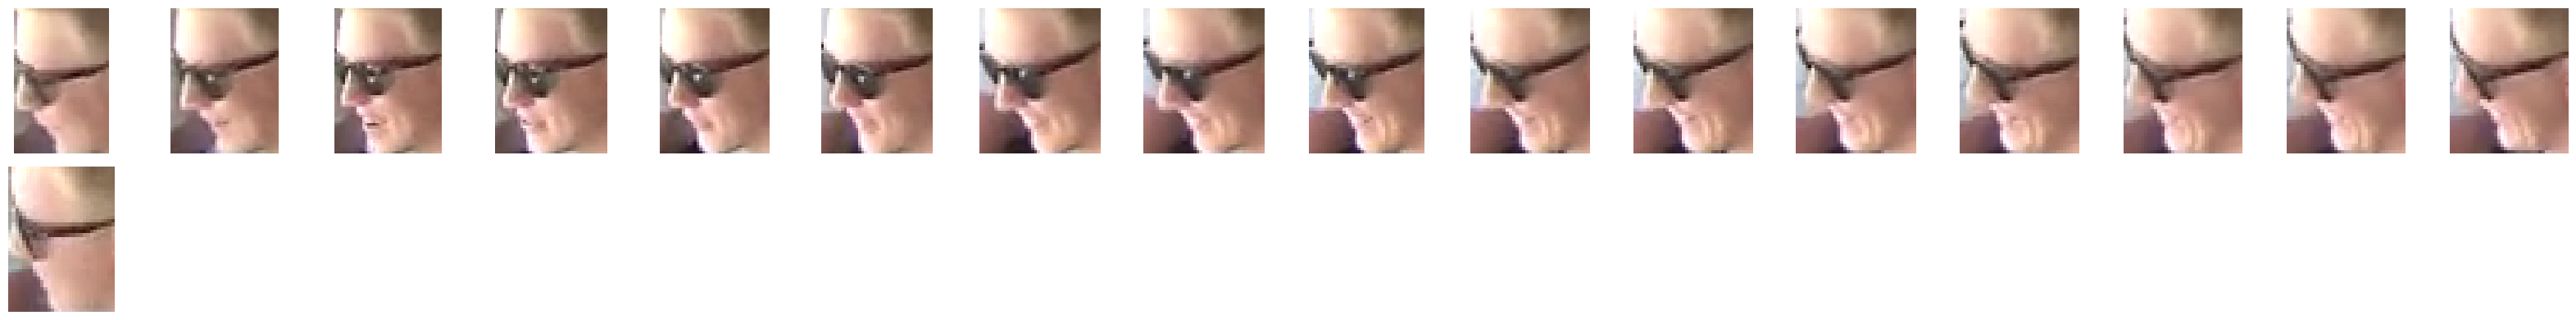

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2

filtered_detections = {}

def reduce_list(items, factor=2, limit=200):
    n = len(items)
    
    # Determine how many items to keep
    keep_count = max(10, min(int(np.sqrt(n) * factor), limit))

    # If we don't need to reduce, return the original list
    if keep_count >= n:
        return items
    
    # Select `keep_count` items spaced evenly across the list
    indices = np.linspace(0, n - 1, keep_count, dtype=int)
    return [items[i] for i in indices]

# Filter frames based on confidence and reduce list size
for detectionid, frames in detections.items():
    # Filter out low-confidence frames
    filtered_frames = {frame_i: face_data for frame_i, face_data in frames.items() if face_data['confidence'] >= 0.8}
    
    # Only keep detections with at least 10 frames after filtering
    if len(filtered_frames) >= 6:
        # Sort by frame number and reduce list size
        reduced_frames = reduce_list(sorted(filtered_frames.items()))

        # Convert back to dictionary format
        filtered_detections[detectionid] = dict(reduced_frames)

# Display detections
for detectionid, frames in filtered_detections.items():
    print(f"Detection: {detectionid}")
    num_frames = len(frames)
    cols = min(16, num_frames)  # Set max 16 columns per row
    rows = math.ceil(num_frames / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    # Flatten axes for easy indexing
    axes = axes.flatten() if num_frames > 1 else [axes]

    for i, (frame_i, face_data) in enumerate(frames.items()):
        #confidence = "{:.2f}".format(face_data['confidence'])
        axes[i].imshow(cv2.cvtColor(face_data['face'], cv2.COLOR_RGB2BGR))  # Convert BGR to RGB if using OpenCV
        axes[i].axis("off")
        #axes[i].set_title(confidence)

    # Hide unused subplots
    for i in range(num_frames, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [4]:
from insightface.model_zoo import get_model

landmark_model = get_model('2d106det', download=True)
landmark_model.prepare(ctx_id=0)  # 0 for GPU, -1 for CPU

for detectionid, frames in filtered_detections.items():
    for i, (frame_i, face_data) in enumerate(frames.items()):
        landmarks = landmark_model.get(cv2.cvtColor(face_data['face'], cv2.COLOR_RGB2BGR))
        print(landmarks)
    


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'NoneType' object has no attribute 'prepare'

In [ ]:
import chromadb

client = chromadb.PersistentClient(path="./facedb")
facedb = client.get_or_create_collection(
    name='facedb',
    metadata={
        "hnsw:space": 'cosine',
    },
)

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import face_recognition

for detectionid, frames in filtered_detections.items():
    query_results = []
    print(f"Detection {detectionid}")
    for i, (frame_i, face_data) in enumerate(frames.items()):
        face = face_data['face']
        face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
        known_face_location = [(0, face.shape[1], face.shape[0], 0)]
        embed = face_recognition.face_encodings(face, known_face_locations=known_face_location)[0]

        qresult = facedb.query(
            query_embeddings=[embed],
            n_results=20
        )
        print(qresult)
        print("\n")
        query_results.append(qresult)
        
        # facedb.add(
        #     ids=[str(detectionid) + ":" +  str(frame_i)],
        #     embeddings=[embed],  # Replace with your embeddings
        #     metadatas=[{'detection': detectionid}]
        # )